<a href="https://colab.research.google.com/github/electronjia/heart_cardiac_mri_image_processing/blob/main/Marching_Cube_Implement_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# from zipfile import ZipFile
# import os

# zip_path = "/content/drive/MyDrive/Colab Notebooks/BME1462 - Biological Image Analysis/Course Project/Patient Data Zips/SCD_IMAGES_01.zip"
# extract_path = "/content/drive/MyDrive/Colab Notebooks/BME1462 - Biological Image Analysis/Course Project/Patient Data Zips/Extracted Files"

# with ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f"Files extracted to: {extract_path}")


In [3]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.3 MB/s eta 0:00:00


In [16]:
import pydicom
import numpy as np
import os

def load_dicom_series(folder_path):
    dicom_files = [pydicom.dcmread(os.path.join(folder_path, f))
                   for f in sorted(os.listdir(folder_path))
                   if f.endswith('.dcm')]

    # Sort files by slice location (if available)
    dicom_files.sort(key=lambda x: float(x.ImagePositionPatient[2]))

    # Stack slices to create a 3D volume
    volume = np.stack([file.pixel_array for file in dicom_files])

    # Get voxel spacing
    slice_thickness = float(dicom_files[0].SliceThickness)
    pixel_spacing = dicom_files[0].PixelSpacing

    spacing = (slice_thickness, pixel_spacing[0], pixel_spacing[1])

    return volume, spacing

folder_path = "/content/drive/MyDrive/Colab Notebooks/BME1462 - Biological Image Analysis/Course Project/Patient Data Zips/Extracted Files/SCD0000101/CINESAX_300"
volume, spacing = load_dicom_series(folder_path)

print(f"Volume shape: {volume.shape}")
print(f"Voxel spacing: {spacing}")


Volume shape: (240, 256, 256)
Voxel spacing: (10.0, '1.367188', '1.367188')


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider

def show_slices(volume):
    """Interactive function to scroll through slices of a 3D volume."""

    def update(slice_idx):
        """Update the displayed image based on the slice index."""
        slice_img = volume[slice_idx]

        # Plot the current slice
        plt.figure(figsize=(6, 6))
        plt.imshow(slice_img, cmap='gray')
        plt.title(f"Slice {slice_idx + 1}/{volume.shape[0]}")
        plt.axis('off')
        plt.show()

    # Create an interactive slider for slice navigation
    interact(update,
             slice_idx=IntSlider(min=0, max=volume.shape[0] - 1, step=1, value=volume.shape[0] // 2))


In [18]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/BME1462 - Biological Image Analysis/Course Project/Patient Data Zips/Extracted Files/SCD0000101/CINELAX_302"
localizer, spacing_localizer = load_dicom_series(folder_path)

print(f"Volume shape: {localizer.shape}")
print(f"Voxel spacing: {spacing_localizer}")

show_slices(localizer)

Volume shape: (100, 256, 256)
Voxel spacing: (8.0, '1.367188', '1.367188')


interactive(children=(IntSlider(value=50, description='slice_idx', max=99), Output()), _dom_classes=('widget-i…

In [7]:
def normalize_volume(volume):
    # Clip out extreme values (optional, helps with outliers)
    volume = np.clip(volume, np.percentile(volume, 1), np.percentile(volume, 99))

    # Min-max normalization to [0, 1]
    volume = volume.astype(np.float32)
    volume -= volume.min()
    volume /= volume.max()

    return volume

normalized_volume = normalize_volume(volume)
show_slices(normalized_volume)


interactive(children=(IntSlider(value=120, description='slice_idx', max=239), Output()), _dom_classes=('widget…

Since the heart is generally centered in the scan, we can create a Gaussian weight map that brightens the center of the image, helping the heart stand out for segmentation.

In [8]:
def apply_center_weighting(volume, alpha=0.5):
    """
    Enhance the image intensity towards the center using a Gaussian weight map.

    Parameters:
    - volume: 3D MRI volume.
    - alpha: Weighting factor (0.0 - 1.0).
    """
    z, y, x = volume.shape

    # Create a Gaussian weight map centered in the middle
    yy, xx = np.meshgrid(np.linspace(-1, 1, x), np.linspace(-1, 1, y))
    distance = np.sqrt(xx**2 + yy**2)
    weight_map = np.exp(-4 * distance**2)  # Gaussian-like falloff

    weighted_volume = np.zeros_like(volume)

    # Apply the weight map to each slice
    for i in range(z):
        weighted_volume[i] = volume[i] * (1 + alpha * weight_map)

    return weighted_volume

# Apply center weighting
weighted_volume = apply_center_weighting(normalized_volume, alpha=0.9)
show_slices(weighted_volume)


interactive(children=(IntSlider(value=120, description='slice_idx', max=239), Output()), _dom_classes=('widget…

The heart is near the center of the image, crop the image to reduce noise and segmentation of other anatomical features

In [9]:
def crop_center(volume, crop_size):
    """
    Crop the center region of a 3D volume.

    Parameters:
    - volume: 3D NumPy array (z, y, x).
    - crop_size: Tuple (crop_height, crop_width).

    Returns:
    - Cropped volume.
    """
    z, y, x = volume.shape
    crop_height, crop_width = crop_size

    # Calculate center coordinates
    center_y, center_x = y // 2, x // 2

    # Define cropping boundaries
    y_min = max(center_y - crop_height // 2, 0)
    y_max = min(center_y + crop_height // 2, y)
    x_min = max(center_x - crop_width // 2, 0)
    x_max = min(center_x + crop_width // 2, x)

    # Crop the volume
    cropped_volume = volume[:, y_min:y_max, x_min:x_max]

    return cropped_volume

# Crop the center 256x256 region
cropped_volume = crop_center(normalized_volume, crop_size=(120, 120))

# Apply center weighting
cropped_volume = apply_center_weighting(cropped_volume, alpha=3)
show_slices(cropped_volume)


interactive(children=(IntSlider(value=120, description='slice_idx', max=239), Output()), _dom_classes=('widget…

Once we’ve boosted the heart region, we can use Otsu’s method for global thresholding. It automatically finds the best threshold value!

In [10]:
from skimage.filters import threshold_otsu

def segment_heart_otsu(volume):
    """
    Segment the heart using Otsu's thresholding after center-weighting.
    """
    segmented_volume = np.zeros_like(volume)

    for i in range(volume.shape[0]):
        slice_img = volume[i]

        # Compute Otsu’s threshold
        thresh = threshold_otsu(slice_img)
        segmented_slice = slice_img > thresh

        segmented_volume[i] = segmented_slice

    return segmented_volume

# Apply segmentation
segmented_volume = segment_heart_otsu(cropped_volume)

show_slices(segmented_volume)


interactive(children=(IntSlider(value=120, description='slice_idx', max=239), Output()), _dom_classes=('widget…

 morphological opening and closing to remove small specks and fill holes

In [11]:
from skimage.morphology import binary_opening, binary_closing, disk

def clean_segmentation(volume, radius=2):
    struct_elem = disk(radius)  # 2D circular element

    cleaned_volume = np.zeros_like(volume)
    for i in range(volume.shape[0]):
        cleaned_slice = binary_closing(binary_opening(volume[i], struct_elem), struct_elem)
        cleaned_volume[i] = cleaned_slice

    return cleaned_volume

cleaned_volume = clean_segmentation(segmented_volume, radius=2)

show_slices(cleaned_volume)


interactive(children=(IntSlider(value=120, description='slice_idx', max=239), Output()), _dom_classes=('widget…

Bias towards circular structures

In [65]:
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects

def filter_circular_regions(segmented_volume, circularity_thresh=0.6, min_size=300):
    """
    Keep only circular regions in a segmented 3D volume.

    Parameters:
    - segmented_volume: 3D binary NumPy array (segmentation mask).
    - circularity_thresh: Circularity threshold (higher = more circular).
    - min_size: Minimum region size to keep (removes small noise).

    Returns:
    - Filtered 3D binary mask with mostly circular regions.
    """
    filtered_volume = np.zeros_like(segmented_volume)

    for z in range(segmented_volume.shape[0]):
        slice_mask = segmented_volume[z]

        # Label connected components
        labeled_mask = label(slice_mask)

        for region in regionprops(labeled_mask):
            # Calculate circularity: (4 * pi * area) / perimeter^2
            if region.perimeter > 0:  # Avoid division by zero
                circularity = (4 * np.pi * region.area) / (region.perimeter ** 2)

                # Keep region if circular enough and above min size
                if circularity >= circularity_thresh and region.area >= min_size:
                    filtered_volume[z][labeled_mask == region.label] = 1

    return filtered_volume

# Apply circular filtering to segmentation
filtered_segmentation = filter_circular_regions(cleaned_volume, circularity_thresh=0.25, min_size=100)

# Visualize the result
show_slices(filtered_segmentation)


interactive(children=(IntSlider(value=120, description='slice_idx', max=239), Output()), _dom_classes=('widget…

In [66]:
from skimage.filters import sobel

def enhance_edges(volume):
    # Apply Sobel filter for edge detection
    edge_volume = np.array([sobel(slice) for slice in volume])

    # Combine with original volume (optional)
    enhanced_volume = volume + edge_volume

    return enhanced_volume

enhanced_volume = enhance_edges(filtered_segmentation)
show_slices(enhanced_volume)


interactive(children=(IntSlider(value=120, description='slice_idx', max=239), Output()), _dom_classes=('widget…

Overlay the edge detected image with the original cropped image

In [67]:
from ipywidgets import interact, IntSlider
import ipywidgets as widgets

def show_slices_with_edges(original_volume, edge_volume):
    """
    Visualize slices of the original MRI with overlaid edge detection results using a slider.

    Parameters:
    - original_volume: 3D NumPy array of the original MRI (z, y, x).
    - edge_volume: 3D NumPy array of the edge-detected MRI.
    """
    z, _, _ = original_volume.shape

    def update(slice_idx):
        plt.figure(figsize=(8, 8))

        # Show original MRI slice
        plt.imshow(original_volume[slice_idx], cmap='gray')

        # Overlay edges with transparency
        plt.imshow(edge_volume[slice_idx], cmap='magma', alpha=0.3)

        plt.title(f'Slice {slice_idx}')
        plt.axis('off')
        plt.show()

    # Create slider to scroll through slices
    interact(update, slice_idx=IntSlider(min=0, max=z - 1, step=1, value=z // 2))


show_slices_with_edges(cropped_volume, enhanced_volume)


interactive(children=(IntSlider(value=120, description='slice_idx', max=239), Output()), _dom_classes=('widget…

Rearrange the MRI Data into a Time-Series 3D Format

In [69]:
import numpy as np

def reshape_mri_data(mri_slices, num_timepoints=20, num_planes=12):
    """
    Reshapes 2D MRI slices into a 4D array (time, z, x, y).

    Parameters:
    - mri_slices: Original stacked MRI slices (240 total).
    - num_timepoints: Number of time frames in the cardiac cycle (20).
    - num_planes: Number of spatial slices in Z (12).

    Returns:
    - time_series_volumes: 4D array of shape (time, z, x, y).
    """
    # Reshape into (num_timepoints, num_planes, H, W)
    time_series_volumes = np.array(mri_slices).reshape(num_timepoints, num_planes, *mri_slices.shape[1:])

    return time_series_volumes

# Reshape the dataset into time-ordered 3D volumes
time_series_volumes = reshape_mri_data(enhanced_volume)


Run Marching Cubes for Each Time Point \\
Now that we have 12 stacked slices for each time frame, we can apply Marching Cubes to reconstruct the heart at each time step.

<ipython-input-61-5183dacbbdf2>:51: RuntimeWarning: invalid value encountered in divide
  volume = np.clip((volume - min_val) / (max_val - min_val), 0, 1)


⚠ Skipping frame 0, no valid structure found.
⚠ Skipping frame 1, no valid structure found.
⚠ Skipping frame 2, no valid structure found.


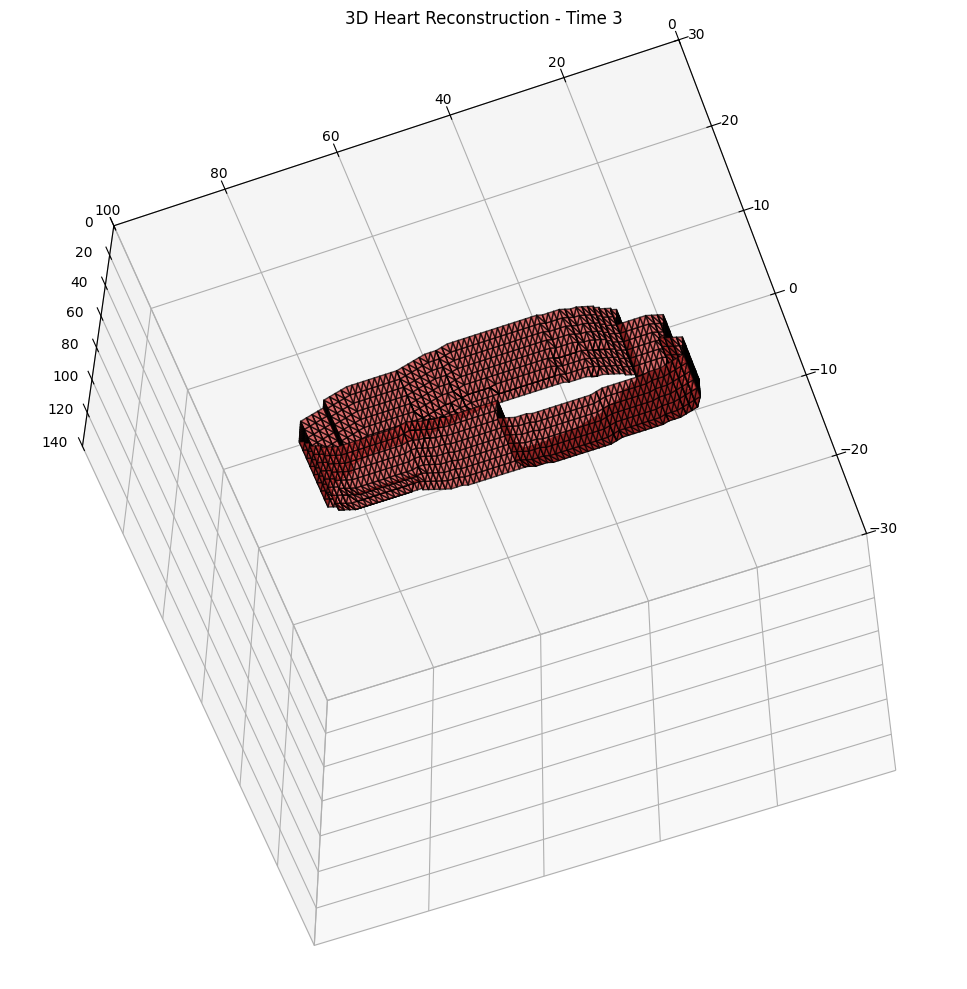

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

⚠ Skipping frame 17, no valid structure found.
⚠ No surface found at level=nan for time 18. Skipping...


<ipython-input-61-5183dacbbdf2>:51: RuntimeWarning: divide by zero encountered in divide
  volume = np.clip((volume - min_val) / (max_val - min_val), 0, 1)


<Figure size 640x480 with 0 Axes>

✅ GIF saved as 'cardiac_cycle.gif'


<Figure size 640x480 with 0 Axes>

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import gaussian_filter
import imageio

def expand_bounding_box(bbox, shape, padding=0.1):
    """
    Expands the bounding box by a given percentage of the volume size.

    Parameters:
    - bbox (tuple of slices): The original bounding box.
    - shape (tuple): The shape of the full volume.
    - padding (float): Fraction of volume size to expand the bounding box.

    Returns:
    - Expanded bounding box as tuple of slices.
    """
    new_bbox = []
    for i, s in enumerate(bbox):
        min_idx = max(s.start - int(padding * shape[i]), 0)
        max_idx = min(s.stop + int(padding * shape[i]), shape[i])
        new_bbox.append(slice(min_idx, max_idx))
    return tuple(new_bbox)

def reconstruct_heart_mesh_4D(time_series_volumes, save_gif=False):
    """
    Run Marching Cubes on the 4D (time-series) MRI volume with automatic centering and expanded bounding box.

    Parameters:
    - time_series_volumes (4D numpy array): (time, depth, height, width)
    - save_gif (bool): If True, saves an animated GIF of the cardiac cycle.

    Returns:
    - Saves a GIF animation of the 3D reconstruction over time.
    """

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    global_shape = time_series_volumes.shape[1:]  # (depth, height, width)

    frames = []  # Store images for GIF

    for t in range(time_series_volumes.shape[0]):  # Iterate over time frames
        volume = time_series_volumes[t]  # Extract 3D volume at time t

        # Normalize per time step
        min_val, max_val = np.percentile(volume, 1), np.percentile(volume, 99)
        volume = np.clip((volume - min_val) / (max_val - min_val), 0, 1)

        # Find bounding box and expand it
        bbox = find_bounding_box(volume, threshold=0.1)
        if bbox is None:
            print(f"⚠ Skipping frame {t}, no valid structure found.")
            continue

        expanded_bbox = expand_bounding_box(bbox, global_shape, padding=0.15)
        cropped_volume = volume[expanded_bbox]

        # Apply Gaussian smoothing to reduce noise
        smoothed_volume = gaussian_filter(cropped_volume, sigma=1)

        if np.std(smoothed_volume) < 0.02:  # Skip frames with too little contrast
            print(f"⚠ Skipping frame {t}, too low contrast.")
            continue

        # Use 60th percentile for thresholding
        level = np.percentile(smoothed_volume, 60)

        try:
            verts, faces, _, _ = marching_cubes(smoothed_volume, level=level)
        except RuntimeError:
            print(f"⚠ No surface found at level={level:.3f} for time {t}. Skipping...")
            continue  # Skip frame if no valid surface

        ax.clear()
        mesh = Poly3DCollection(verts[faces], alpha=0.7, edgecolor='k')
        mesh.set_facecolor((0.8, 0.2, 0.2))
        ax.add_collection3d(mesh)

        # Set fixed axis limits based on the full heart volume
        ax.set_xlim(-10, 30)  # Width
        ax.set_ylim(0, 100)  # Height
        ax.set_zlim(0, 140)  # Depth

        ax.view_init(elev=120, azim=160)  # Adjust camera angle
        ax.set_title(f"3D Heart Reconstruction - Time {t}")
        plt.tight_layout()

        plt.pause(0.1)
        plt.draw()

        # Save each frame for GIF animation
        if save_gif:
            fig.canvas.draw()
            image = np.array(fig.canvas.renderer.buffer_rgba())
            frames.append(image)

    if save_gif and frames:
        imageio.mimsave("cardiac_cycle.gif", frames, fps=5)
        print("✅ GIF saved as 'cardiac_cycle.gif'")

# Run improved marching cubes reconstruction
reconstruct_heart_mesh_4D(time_series_volumes, save_gif=True)


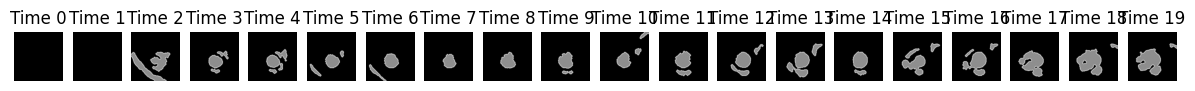

<ipython-input-70-9772e4d00da0>:42: RuntimeWarning: invalid value encountered in divide
  volume = np.clip((volume - min_val) / (max_val - min_val), 0, 1)


⚠ No surface found at level=nan for time 0. Skipping...


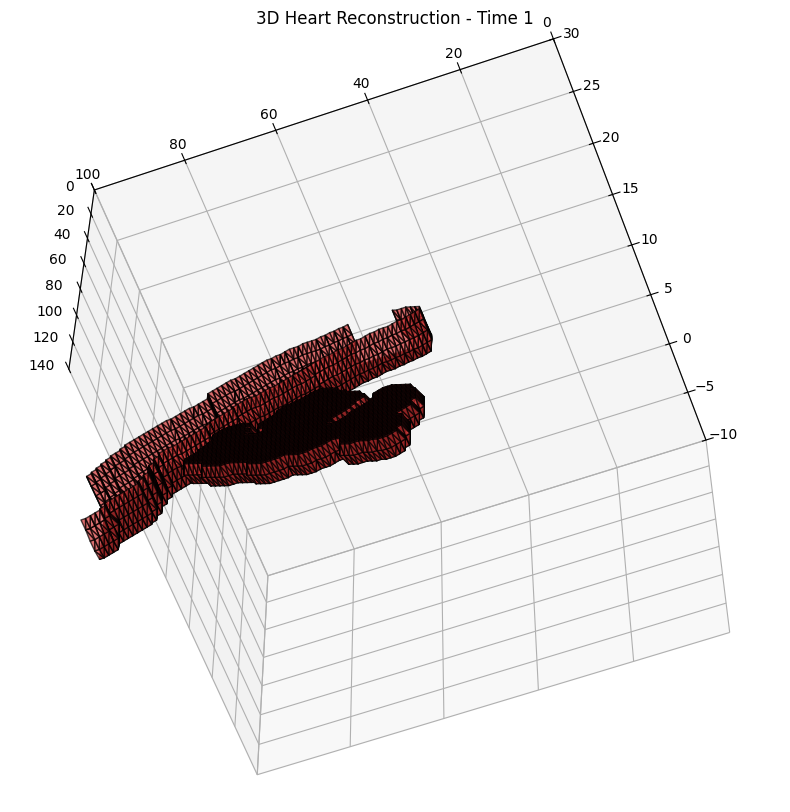

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

✅ GIF saved as 'cardiac_cycle.gif'


<Figure size 640x480 with 0 Axes>

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
import imageio

def verify_4D_data(time_series_volumes):
    """
    Visualizes a mid-slice of the 4D MRI volume over time to check correctness.
    """
    mid_slice = time_series_volumes.shape[1] // 2  # Mid depth slice

    fig, axes = plt.subplots(1, time_series_volumes.shape[0], figsize=(15, 5))
    for t in range(time_series_volumes.shape[0]):
        axes[t].imshow(time_series_volumes[t, mid_slice, :, :], cmap='gray')
        axes[t].set_title(f"Time {t}")
        axes[t].axis("off")
    plt.show()

def reconstruct_heart_mesh_4D(time_series_volumes, save_gif=False):
    """
    Run Marching Cubes on the 4D (time-series) MRI volume with dynamic thresholding.

    Parameters:
    - time_series_volumes (4D numpy array): (time, depth, height, width)
    - save_gif (bool): If True, saves an animated GIF of the cardiac cycle.
    """

    # Verify data format
    verify_4D_data(time_series_volumes)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    frames = []  # Store images for GIF

    for t in range(time_series_volumes.shape[0]):  # Iterate over time frames
        volume = time_series_volumes[t]  # Extract 3D volume at time t

        # Normalize contrast within each time step
        min_val, max_val = np.percentile(volume, 1), np.percentile(volume, 99)
        volume = np.clip((volume - min_val) / (max_val - min_val), 0, 1)

        # Adaptive thresholding: use 90th percentile of voxel intensities
        level = np.percentile(volume, 90)

        try:
            verts, faces, _, _ = marching_cubes(volume, level=level)
        except RuntimeError:
            print(f"⚠ No surface found at level={level:.3f} for time {t}. Skipping...")
            continue  # Skip frame if no valid surface

        ax.clear()
        mesh = Poly3DCollection(verts[faces], alpha=0.7, edgecolor='k')
        mesh.set_facecolor((0.8, 0.2, 0.2))
        ax.add_collection3d(mesh)

        # Fix axis limits across frames
        ax.set_xlim(-5, 30)  # Width
        ax.set_ylim(20, 100)  # Height
        ax.set_zlim(0, 140)  # Depth

        ax.view_init(elev=120, azim=160)  # Adjust camera angle
        ax.set_title(f"3D Heart Reconstruction - Time {t}")

        plt.pause(0.1)
        plt.draw()

        # Save each frame for GIF animation
        if save_gif:
            fig.canvas.draw()
            image = np.array(fig.canvas.renderer.buffer_rgba())
            frames.append(image)

    if save_gif and frames:
        imageio.mimsave("cardiac_cycle.gif", frames, fps=5)
        print("✅ GIF saved as 'cardiac_cycle.gif'")

# Run improved marching cubes reconstruction
reconstruct_heart_mesh_4D(time_series_volumes, save_gif=True)
